In [1]:
!pip install phantominator
!wget -qO- https://raw.githubusercontent.com/matteo-ronchetti/torch-radon/master/auto_install.py  | python -
!pip install simpleitk

Checking requirements
Operating System: linux OK
Python version: 3.7 OK
PyTorch: 1.8 ERROR
Precompiled packages are build for PyTorch 1.5 to 1.7
Consider manually compiling torch-radon


In [68]:
import numpy as np
import scipy as sp
from scipy import io
import matplotlib.pyplot as plt
import phantominator as ph
from skimage.transform import radon, iradon
# import cupy as cp
from time import time
import sys
import pickle

sys.path.append('/content/drive/MyDrive/Balseiro/Maestría/Implementación/0-CS/')
sys.path.append('/content/drive/MyDrive/Balseiro/Maestría/Implementación/1-DL/')
%load_ext autoreload
%autoreload 1
%aimport Reconstruction
%aimport DataLoading 
%aimport ReconstructionHessian

rc = Reconstruction
dl = DataLoading
rh = ReconstructionHessian

from skimage.metrics import structural_similarity as ssim
from numpy.linalg import norm
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Folder Paths

f140114_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140114_5dpf"  # 5 days post-fertilization
f140117_3dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140117_3dpf"  # 3 days post-fertilization
f140115_1dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140315_1dpf"  # 1 days post-fertilization

f140315_3dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140315_3dpf"     # 3 days post-fertilization
f140415_5dpf_4X = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140415_5dpf_4X"  # 5 days post-fertilization
f140419_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140519_5dpf"     # 5 days post-fertilization

f140714_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140714_5dpf"
f140827_3dpf_4X = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140827_3dpf_4X"
f140827_5dpf_4X = '/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140827_5dpf_4X'

folder_paths = [f140114_5dpf, f140117_3dpf, f140115_1dpf, f140315_3dpf, f140415_5dpf_4X, f140419_5dpf, f140714_5dpf, f140827_3dpf_4X, f140827_5dpf_4X]
results_folder = '/content/drive/MyDrive/Balseiro/Maestría/Implementación/1-DL/Resultados/'

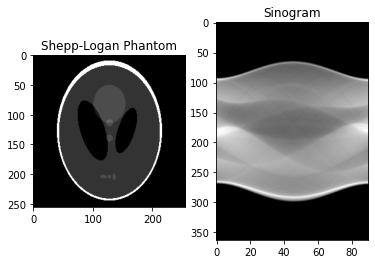

In [77]:
# Shepp-Logan phantom
phant = np.flipud(ph.shepp_logan(256))

# Number of beams
beams = 90

# Angles
theta = np.linspace(0., 180.-180/beams, beams)

# Sinogram
sino = radon(phant, theta = theta, circle = False)

plt.subplot(121), plt.imshow(phant, cmap = 'gray'), plt.title('Shepp-Logan Phantom')
plt.subplot(122), plt.imshow(sino, cmap = 'gray', aspect = 'auto'), plt.title('Sinogram')
plt.show()

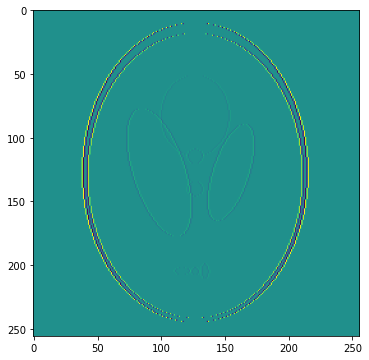

In [ ]:
# Testing denoiser

h = rh.hessianOperator(phant)
Hadj = rh.adjHessianOp(h)
h_new = np.array([[h[:,:,0], h[:,:,1]],[h[:,:,1], h[:,:,2]]]).T

fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.imshow(h[:,:,2])

In [ ]:
hess = rh.hessianOperator(phant)
_, d, _ = np.linalg.svd(hess)

In [ ]:
# Noisy image
sigma = 0.1
phant_noise = phant + sigma*np.random.randn(phant.size).reshape(phant.shape)

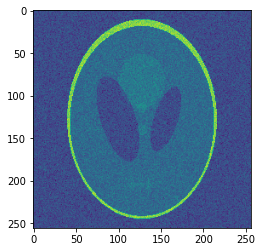

In [ ]:
plt.imshow(phant_noise)

In [ ]:
# Test for Hessian Reconstruction
sigma = 0.1
phant_noise = phant + sigma*np.random.randn(phant.size).reshape(phant.shape)

iter = 5

kwargs = {'MAX_ITER':iter,
          'VERBOSE':True,
          'IMAGE':phant,
          'SNORM': 'spectral',  # spectral S1
          'OPTIM' : 'FGP',
          'BOUNDS' : [-np.inf, np.inf],
          'ORDER': 1}

phant_hdenoise_spectral = rh.denoiseHessian(phant_noise, 0.001, kwargs) # empirico 0.001 aunque habría que chequar piola
kwargs['SNORM'] = 'frobenius' # Frobenius S2
phant_hdenoise_frobenius = rh.denoiseHessian(phant_noise, 0.001, kwargs)
kwargs['SNORM'] = 'nuclear'  # Nuclear Sinf 
phant_hdenoise_nuclear = rh.denoiseHessian(phant_noise, 0.001, kwargs)
phant_tvdenoise = rc.TVdenoise(phant_noise, 0.001, iter)

******************************************

**  Denoising with Hessian Regularizer  **

******************************************

#iter     relative-dif   	 fun_val         Duality Gap        ISNR


0 	  1.0 	 27.688598948548083 	 15.142716957634953 	  0.13029662924892219

1 	  0.3391384440711636 	 28.253123235481617 	 14.659490877925073 	  0.1182723300120249

2 	  0.20679773587669942 	 28.374949471166364 	 14.313694907308108 	  0.10961991770776472

3 	  0.1314410551850722 	 28.243920730196884 	 12.914967329529723 	  0.12130994884042372

4 	  0.08802324488461911 	 28.055840707776298 	 11.4230829217652 	  0.13950641786034737

******************************************

**  Denoising with Hessian Regularizer  **

******************************************

#iter     relative-dif   	 fun_val         Duality Gap        ISNR


0 	  1.0 	 28.521137561157698 	 23.78214645507907 	  0.059561975611325944

1 	  0.06775988386182685 	 28.498076108242053 	 23.612665788044573 	  0.06138076168026442

In [ ]:
# frobenius
iter = 10

kwargs = {'MAX_ITER':iter,
          'VERBOSE':True,
          'IMAGE':phant,
          'SNORM': 'nuclear',  
          'OPTIM' : 'FGP',
          'BOUNDS' : [-np.inf, np.inf],
          'ORDER': 1}

phant_hdenoise_frobenius = rh.denoiseHessian(phant_noise, 0.001, kwargs)

print('MSE noise', 10*np.log10(np.linalg.norm(phant_noise.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Frobenius', 10*np.log10(np.linalg.norm(phant_hdenoise_frobenius.flatten()-phant.flatten())))

fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(phant_hdenoise_frobenius)

fig.show()

NameError: ignored

******************************************

**  Denoising with Hessian Regularizer  **

******************************************

#iter     relative-dif   	 fun_val         Duality Gap        ISNR


0 	  1.0 	 7.136505964701435 	 6.778119859815895 	  0.046683540395934524

1 	  0.38866354825421 	 7.164973697946958 	 6.799673382386923 	  -0.018646605176732375

2 	  0.2452350830821954 	 7.133881843266993 	 6.741987561132321 	  -0.012293334572991758

3 	  0.1676151214296511 	 7.114218266636751 	 6.71026303050601 	  -0.003139215804216738

4 	  0.12396222878562349 	 7.101839522603067 	 6.692634932079708 	  0.0038780367384557597

5 	  0.09666866048194053 	 7.092558898188193 	 6.685745620276569 	  0.010321567591970348

6 	  0.07929902378387974 	 7.086156127579969 	 6.68192787618689 	  0.014140514196145119

7 	  0.0676728524537912 	 7.081190471148943 	 6.67400104363594 	  0.017809178441413484

8 	  0.05895216136095419 	 7.077461901638307 	 6.667746190963689 	  0.020986892368204425

9 	  0.052

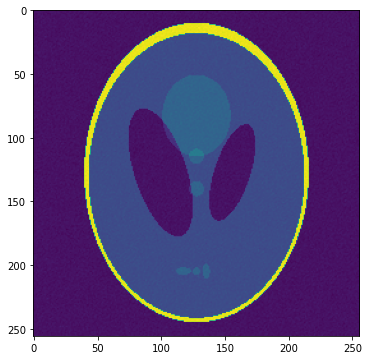

In [ ]:
# nuclear
kwargs['SNORM'] = 'nuclear'
kwargs['MAX_ITER'] = 10

phant_hdenoise_nuclear = rh.denoiseHessian(phant_noise, 0.001, kwargs)

print('MSE noise', 10*np.log10(np.linalg.norm(phant_noise.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Nuclear', 10*np.log10(np.linalg.norm(phant_hdenoise_nuclear.flatten()-phant.flatten())))

fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(phant_hdenoise_nuclear)

fig.show()

******************************************

**  Denoising with Hessian Regularizer  **

******************************************

#iter     relative-dif   	 fun_val         Duality Gap        ISNR


0 	  1.0 	 7.130866807601234 	 6.698564745546247 	  0.06260791533374288

1 	  0.38902834245697826 	 7.152464149078893 	 6.691702995400844 	  0.009878172039843577

2 	  0.24575431648679769 	 7.121453531925616 	 6.630184037344114 	  0.013191646266346054

3 	  0.16851632683454473 	 7.101569541167162 	 6.583583902258322 	  0.020150108838338576

4 	  0.12402267632061972 	 7.088398670037414 	 6.545849234193675 	  0.026992581142010863

5 	  0.0972894313723228 	 7.079729117128683 	 6.528985662262859 	  0.0315851199430361

6 	  0.07987192678931686 	 7.073211822691073 	 6.5238770181422385 	  0.035533159259549064

7 	  0.06790671760750759 	 7.068249987629927 	 6.5222337311007985 	  0.03843465368471938

8 	  0.05931718559436685 	 7.064617402423073 	 6.522039057480333 	  0.04064037667559777

9 	  0.05

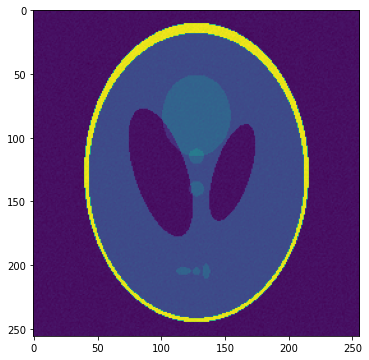

In [ ]:
# Spectral
phant_hdenoise_spectral = rh.denoiseHessian(phant_noise, 0.001, kwargs)

print('MSE noise', 10*np.log10(np.linalg.norm(phant_noise.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Spectral', 10*np.log10(np.linalg.norm(phant_hdenoise_spectral.flatten()-phant.flatten())))

fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(phant_hdenoise_spectral)

fig.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd7e0ee2b90>,
 Text(0.5, 1.0, 'Denoised, Hessian/Nuclear'))

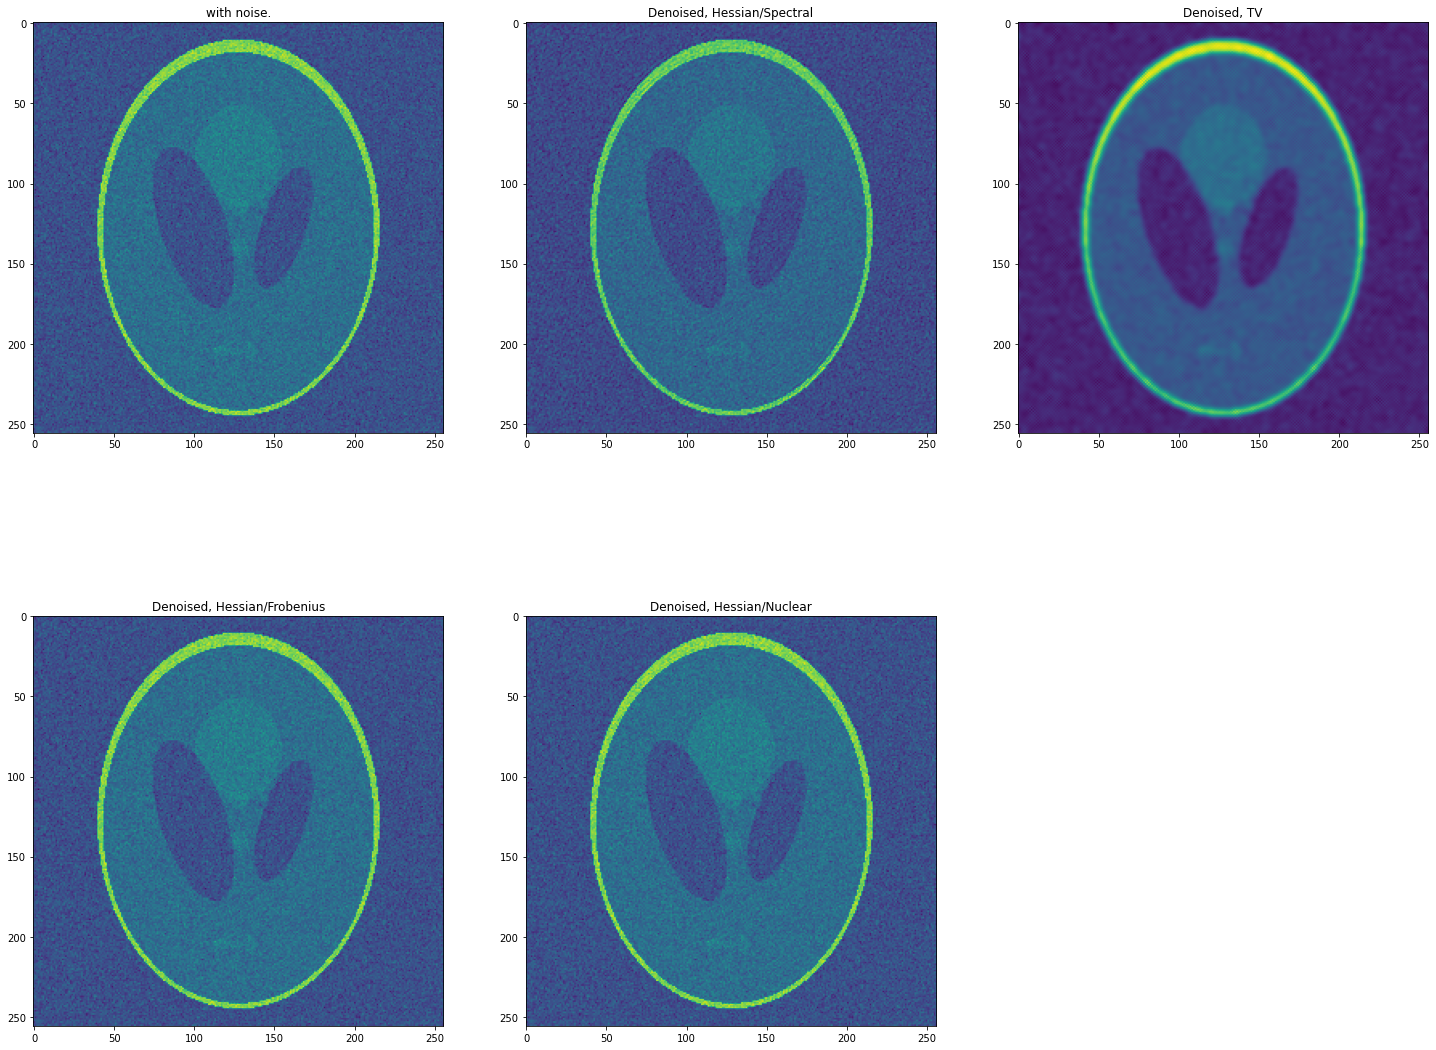

In [ ]:
plt.figure(figsize=(25, 20))
plt.subplot(231), plt.imshow(phant_noise), plt.title('with noise.')
plt.subplot(232), plt.imshow(phant_hdenoise_spectral), plt.title('Denoised, Hessian/Spectral')
plt.subplot(233), plt.imshow(phant_tvdenoise), plt.title('Denoised, TV')
plt.subplot(234), plt.imshow(phant_hdenoise_frobenius), plt.title('Denoised, Hessian/Frobenius')
plt.subplot(235), plt.imshow(phant_hdenoise_nuclear), plt.title('Denoised, Hessian/Nuclear')

In [ ]:
print('MSE noise', 10*np.log10(np.linalg.norm(phant_noise.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Spectral', 10*np.log10(np.linalg.norm(phant_hdenoise_spectral.flatten()-phant.flatten())))
print('MSE denoised - TV', 10*np.log10(np.linalg.norm(phant_tvdenoise.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Frobenius', 10*np.log10(np.linalg.norm(phant_hdenoise_frobenius.flatten()-phant.flatten())))
print('MSE denoised - Hessian/Nuclear', 10*np.log10(np.linalg.norm(phant_hdenoise_nuclear.flatten()-phant.flatten())))

MSE noise 14.089954621710842
MSE denoised - Hessian/Spectral 14.027267610962062
MSE denoised - TV 13.444978249625068
MSE denoised - Hessian/Frobenius 14.058506962420234
MSE denoised - Hessian/Nuclear 14.062399404448076


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd7e027c4d0>,
 <matplotlib.image.AxesImage at 0x7fd7e009ac10>)

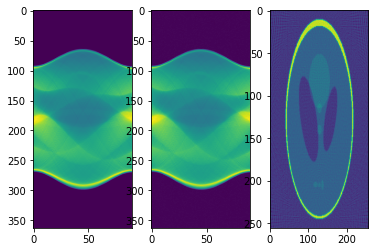

In [ ]:
sigma = 0.2
y = sino+sigma*np.random.randn(sino.size).reshape(sino.shape)
fbp = hRT(y)

plt.subplot(131), plt.imshow(sino, aspect = 'auto')
plt.subplot(132), plt.imshow(y, aspect = 'auto')
plt.subplot(133), plt.imshow(fbp, aspect = 'auto')


In [ ]:
## Testing TwIST with TV
# Denoising function -  total variation used here
# Change if necessary - strength of total variarion
tv_iters = 3;

Psi = lambda x,th:  rc.TVdenoise(x,2/th,tv_iters)

#  set the penalty function, to compute the objective
Phi = lambda x: rc.TVnorm(x)
hR = lambda x: radon(x, theta, circle = False)
hRT = lambda sino: iradon(sino, theta, circle = False)
#  regularization parameters (empirical)  
# Change if necessary - high value will blur the image
tau = 0.001;              

tolA = 1e-4
#  -- TwIST ---------------------------
#  stop criterium:  the relative change in the objective function 
# % falls below 'ToleranceA'         
kwargs = {'Lambda':1e-4,
         'AT':hRT,
         'Psi':Psi,
         'Phi':Phi, 
         'GPU' : 0,
         'True_x':phant,
         'Monotone':1,
         'MaxiterA':10000,
         'Initialization':0,
         'StopCriterion':1,
       	 'ToleranceA':tolA,
         'Verbose': 1}

x_twist,dummy,obj_twist, times_twist,dummy,mse_twist, max_svd = rc.TwIST(y, hR, tau, kwargs)

1 
 Initial objective = 14674535.567596748,  nonzeros=0.0 

Iteration=2, objective=3460.540460175093, nz=65536,  criterion=9997.641805804187

Incrementing S=2

Iteration=3, objective=1278.3457676101805, nz=65536,  criterion=6305.936074663032

Iteration=4, objective=1008.7639462975428, nz=65536,  criterion=2108.833369993556

Incrementing S=4

Iteration=5, objective=280.36329196080374, nz=65536,  criterion=7220.724501605963

Iteration=6, objective=250.4167272820022, nz=65536,  criterion=1068.1342935218574

Iteration=7, objective=207.9022027499264, nz=65536,  criterion=1697.7509846696

Iteration=8, objective=201.70612201586945, nz=65536,  criterion=298.02862365579927

Iteration=9, objective=200.43342877602603, nz=65536,  criterion=63.09641111157199

Iteration=10, objective=196.90046103390154, nz=65536,  criterion=176.2663924725055

Iteration=11, objective=193.99216588651214, nz=65536,  criterion=147.7038261931066

Iteration=12, objective=191.96613294610376, nz=65536,  criterion=104.438905

In [ ]:
## Testing TwIST with Hessian
# Denoising function -  total variation used here
# Change if necessary - strength of total variarion
hess_iters = 3;
kwargs_hess = {'MAX_ITER':hess_iters,
          'VERBOSE':False,
          'IMAGE':phant,
          'SNORM': 'frobenius',  
          'OPTIM' : 'FGP',
          'BOUNDS' : [-np.inf, np.inf],
          'ORDER': 1}

Psi = lambda x,th:  rh.denoiseHessian(x, th, kwargs_hess)

#  set the penalty function, to compute the objective
Phi = lambda x: rh.mixedSchattenNorm(x, 2)
hR = lambda x: radon(x, theta, circle = False)
hRT = lambda sino: iradon(sino, theta, circle = False)
#  regularization parameters (empirical)  
# Change if necessary - high value will blur the image
tau = 0.001     

tolA = 1e-4
#  -- TwIST ---------------------------
#  stop criterium:  the relative change in the objective function 
# % falls below 'ToleranceA'         
kwargs = {'Lambda':1e-4,
         'AT':hRT,
         'Psi':Psi,
         'Phi':Phi, 
         'GPU' : 0,
         'True_x':phant,
         'Monotone':1,
         'MaxiterA':10000,
         'Initialization':0,
         'StopCriterion':1,
       	 'ToleranceA':tolA,
         'Verbose': 1}

x_hess_frobenius,dummy,obj_twist, times_twist,dummy,mse_twist, max_svd = rc.TwIST(y, hR, tau, kwargs)

# kwargs_hess['SNORM'] = 'spectral'
# Psi = lambda x,th:  rh.denoiseHessian(x, th, kwargs_hess)
# Phi = lambda x: rh.hessNorm(x, kwargs_hess['SNORM'], 1)
# x_hess_spectral, dummy, obj_twist, times_twist, dummy, mse_twist, max_svd = rc.TwIST(y, hR, tau, kwargs)

# kwargs_hess['SNORM'] = 'nuclear'
# Psi = lambda x,th:  rh.denoiseHessian(x, th, kwargs)
# x_hess_nuclear, dummy, obj_twist, times_twist, dummy, mse_twist, max_svd = rc.TwIST(y, hR, tau, kwargs)

1 
 Initial objective = 14674535.567596748,  nonzeros=0.0 

Iteration=2, objective=3547.473979637391, nz=65536,  criterion=9997.582564733788

Incrementing S=2

Iteration=3, objective=1209.1094420585428, nz=65536,  criterion=6591.632668769756

Iteration=4, objective=869.4529684719874, nz=65536,  criterion=2809.145820648631

Iteration=5, objective=799.886747528809, nz=65536,  criterion=800.1148246746112

Incrementing S=4

Iteration=6, objective=240.0515101179967, nz=65536,  criterion=6998.931275463456

Iteration=7, objective=228.00147451766847, nz=65536,  criterion=501.9770796028352

Iteration=8, objective=214.8571830247445, nz=65536,  criterion=576.5002845148434

Iteration=9, objective=211.31141186693625, nz=65536,  criterion=165.02921186488283

Iteration=10, objective=210.9429666972874, nz=65536,  criterion=17.436122658669397

Iteration=11, objective=210.53603707908684, nz=65536,  criterion=19.290978247429628

Iteration=12, objective=210.34497202880445, nz=65536,  criterion=9.075170832

	MSE denoised	SSIM 
FBP	 11.408779487479295 0.737010575843742
Hess-Frobenius	 11.226326275948521 0.7726696326497312
TV	 10.003129619257404 0.8794884107245045


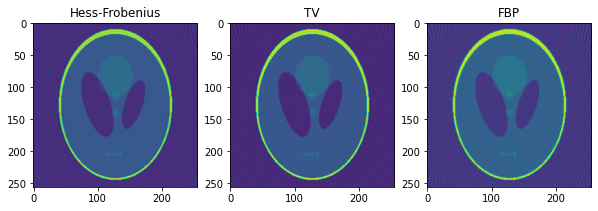

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (10, 8))

ax[0].imshow(x_hess_frobenius), ax[0].set_title('Hess-Frobenius')
ax[1].imshow(x_twist), ax[1].set_title('TV')
ax[2].imshow(fbp), ax[2].set_title('FBP')
# ax[3].imshow(x_hess_spectral), ax[3].set_title('Hess-Spectral')
print('\tMSE denoised\tSSIM ')

print('FBP\t', 10*np.log10(np.linalg.norm(phant.flatten()-fbp.flatten())), ssim(phant, fbp))
print('Hess-Frobenius\t', 10*np.log10(np.linalg.norm(phant.flatten()-x_hess_frobenius.flatten())), ssim(phant, x_hess_frobenius))
print('TV\t', 10*np.log10(np.linalg.norm(phant.flatten()-x_twist.flatten())), ssim(phant, x_twist))


# print('Hess-Spectral\t', 10*np.log10(np.linalg.norm(phant.flatten()-x_hess_spectral.flatten())))

Reconstrucción ---------- 
$\sigma$ = 0.2 - TV_iter = 3 - Tau = 0.001 
Error FBP :23.359140560113953 
Error TV: 15.016236933274804 
Error Hessian-TVdenoise: 15.34867640306729


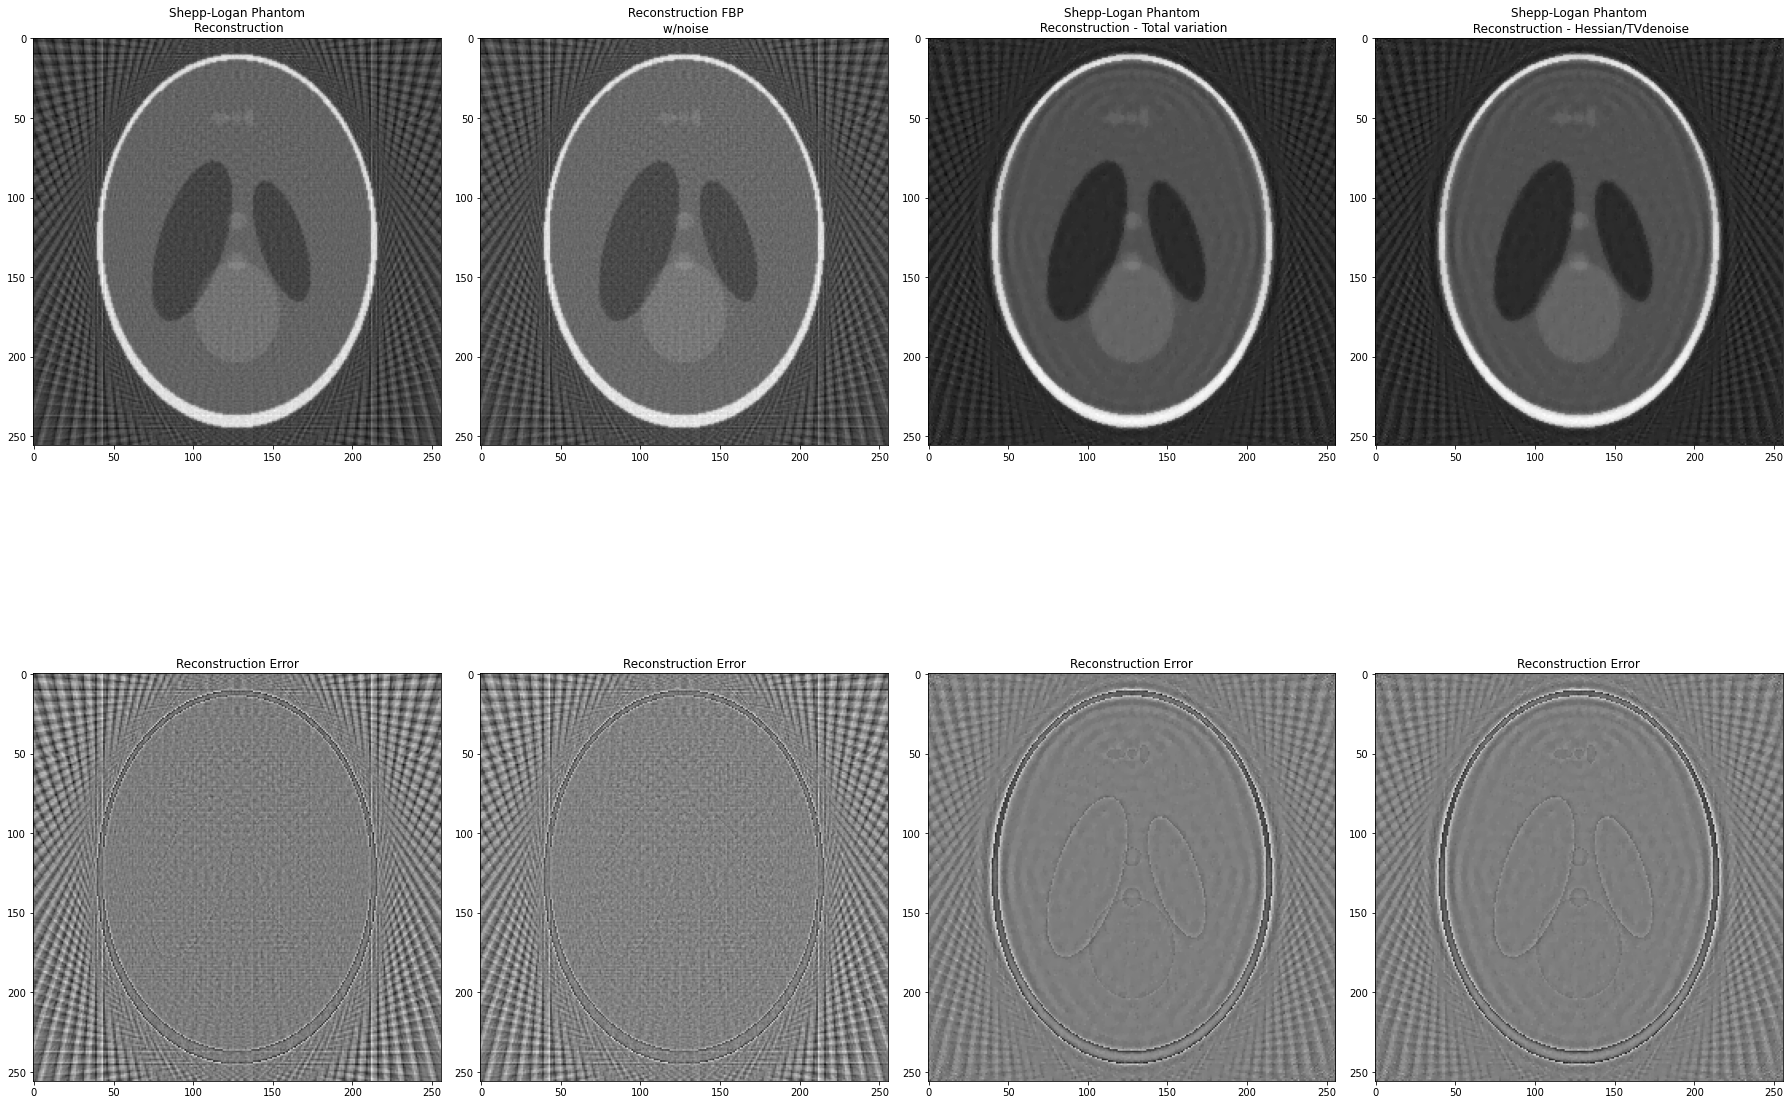

In [ ]:
# Reconstrucción mediante FBP y TV
reconstruct = iradon(sino, theta = theta, circle = False)
reconstruct_noise = iradon(y, theta = theta, circle = False)

print('Reconstrucción ---------- \n$\sigma$ = {} - TV_iter = {} - Tau = {} \nError FBP :{} \nError TV: {} \nError Hessian-TVdenoise: {}'.format(sigma, tv_iters, tau, np.linalg.norm((reconstruct-phant).flatten()), np.linalg.norm((x_twist-phant).flatten()), np.linalg.norm((x_hess_twist-phant).flatten())))
fig, ax = plt.subplots(2,4, figsize = (25, 20))

ax[0,0].imshow(reconstruct, cmap = 'gray')
ax[0,0].set_title('Shepp-Logan Phantom\n Reconstruction')

ax[1,0].imshow(reconstruct-phant, cmap = 'gray')
ax[1,0].set_title('Reconstruction Error')

ax[0,1].imshow(reconstruct_noise, cmap = 'gray')
ax[0,1].set_title(' Reconstruction FBP\n w/noise')

ax[1,1].imshow(reconstruct_noise-phant, cmap = 'gray')
ax[1,1].set_title('Reconstruction Error')

ax[0,2].imshow(x_twist, cmap = 'gray')
ax[0,2].set_title('Shepp-Logan Phantom\n Reconstruction - Total variation')

ax[1,2].imshow(x_twist-phant, cmap = 'gray')
ax[1,2].set_title('Reconstruction Error')

ax[0,3].imshow(x_hess_twist, cmap = 'gray')
ax[0,3].set_title('Shepp-Logan Phantom\n Reconstruction - Hessian/TVdenoise')

ax[1,3].imshow(x_hess_twist-phant, cmap = 'gray')
ax[1,3].set_title('Reconstruction Error')

plt.tight_layout()

In [ ]:
# Load HDF reader
import h5py
filepath = '/content/drive/MyDrive/Balseiro/Maestría/Implementación/OPT_4Marcos/Fish1Fluo800DATA.mat'

# Same operation with Fish OPT
f = h5py.File(filepath)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [ ]:
# Loading and subsampling

beams = 800
angle = 360/beams
angles_total = np.linspace(0, 360-angle, beams)              # for hRT
angles_half_total = angles_total[angles_total<180]           # for hR 
angles_half2_total = angles_total[angles_total>=180]-180

# reduced number of projections - change
Rbeams = 90
Rangle = 360/Rbeams
angles = np.linspace(0,360-Rangle,Rbeams) # for hRT

idx = []
# Indexing - ask Teresa about these sampling conditions

for i in range(0,Rbeams):
   
   if  sum(angles_total == angles[i]) == 1:
       I = np.where(angles_total == angles[i])[0][0]

   elif  sum(np.round(angles_total) == angles[i]) == 1:
       
       Ir = np.round(angles_total) == angles[i]
       ii = np.argsort(abs(angles_total[Ir] - angles[i]))
       I = Ir[ii[0]]
   else:       
       Ib = np.where(angles_total <= angles[i])
       It = np.where(angles_total >= angles[i])
       Ir = [Ib[0][-1], It[0][0]]
       ii = np.argsort(abs(angles_total[Ir] - angles[i]))
       I = Ir[ii[0]] 
   
   idx.append(I)

Rangles = angles_total[idx]
Rangles_half = Rangles[Rangles<180]         # for hR 
Rangles_half2 = Rangles[Rangles>=180]-180

fish_raw_data = f['Dfluo800'][idx,:,:]      # Different loading than Matlab :
                                            # Matlab : [image size, z-slices, number of projections]
                                            # Python : [number of projections, z-slices, image size]

In [ ]:
# Resizing for reconstruction zero padding
N = fish_raw_data.shape[2]

# just one slice
zpt = np.ceil((2*np.ceil(norm(np.array(recon[0,:,:].shape)-np.floor((np.array(recon[0,:,:].shape)-1)/2)-1))+3 - N)/2).astype(int)
zpb = np.floor((2*np.ceil(norm(np.array(recon[0,:,:].shape)-np.floor((np.array(recon[0,:,:].shape)-1)/2)-1))+3 - N)/2).astype(int)
st = abs(zpb - zpt)

j = 1000    # to do 3D reconstruction change to j=1:slices

count = 0
R = []
for i in range(0, fish_raw_data.shape[0]):
  
  count = count + 1

  R.append(np.pad(np.squeeze(fish_raw_data[i, j, :]), (zpb, zpt)).astype(float))
  
R = np.array(R)

In [ ]:
# easier padding
fish_pad = np.pad(fish_raw_data, ((0,0), (0,0), (zpb, zpt)))

In [ ]:
# FBP reconstruction 4 Fish
hR = lambda x: rc.hR2(x, Rangles_half, Rangles_half2)
hRT = lambda x: iradon(x, Rangles, circle = False)
FB_fish = []
# reconstruction via FBP with subsampling, only for visualization
for i in range(0, 10):
  FB_fish.append(hRT(fish_pad[:, i*4, :].T))
# section with FBP

FB_fish = np.array(FB_fish)

plt.imshow(np.mean(FB_fish, axis = 1).T, aspect = 'auto')

NameError: ignored

In [ ]:
## Testing ADMM with TV

# Shepp-Logan phantom
phant = np.flipud(ph.shepp_logan(256))
# Number of beams
beams = 90
# Angles
theta = np.linspace(0., 180.-180/beams, beams)

# Sinogram
sino = radon(phant, theta = theta, circle = False)

# Denoising function -  total variation used here
# Change if necessary - strength of total variarion
tv_iters = 3;

Psi = lambda x,th:  rc.TVdenoise(x,2/th,tv_iters)

#  set the penalty function, to compute the objective
Phi = lambda x: rc.TVnorm(x)
hR = lambda x: radon(x, theta, circle = False)
hRT = lambda sino: iradon(sino, theta, circle = False)

sigma = 0.1
y = sino+sigma*np.random.randn(sino.size).reshape(sino.shape)

x_ADMM_TV, objective, error_MSE_TV, error_SSIM_TV = rc.ADMM(y, hR, hRT, Psi, alpha = 0.01,
                                                delta = 1, max_iter = 20, phi = Phi, 
                                                tol = 1e-4, warm = 1, invert = 0, img = phant)

ADMM reconstruction
Iteration | ISNR | objective | criterion | Phi Norm
----
2	|-7.883	|3673523.7767621763	|10974445.694414796	0.13605546665340293
3	|-3.082	|921716.088735238	|7490.921129826923	0.1923334877749146
4	|0.406	|233153.41439947687	|7470.442175752777	0.22927088435094692
5	|2.501	|60034.325797298945	|7425.114877604226	0.2508449737439383
6	|3.748	|15696.544853386948	|7385.4049920731895	0.26469378247351677
7	|4.636	|4177.919866685734	|7338.318779253998	0.27458891189800827
8	|5.396	|1180.0449540001243	|7175.520374601553	0.28239164692497787
9	|6.114	|397.9477952210598	|6627.689531046308	0.28904718915487676
10	|6.817	|191.54431644451083	|5186.697382300909	0.29502732414303373
11	|7.514	|135.18631460366876	|2942.2956988216674	0.3005567087914426
12	|8.202	|118.37892404510643	|1243.276037802883	0.3057242387686192
13	|8.881	|112.28695816208275	|514.6157504103033	0.31055341815957027
14	|9.545	|109.27842423256989	|267.9326235884081	0.31504020603131094
15	|10.19	|107.28261129381217	|182.63

In [ ]:
# Testing ADMM with Hessian
hess_iters = 3
kwargs_hess = {'MAX_ITER':hess_iters,
          'VERBOSE':False,
          'IMAGE':phant,
          'SNORM': 'nuclear',  
          'OPTIM' : 'FGP',
          'BOUNDS' : [-np.inf, np.inf],
          'ORDER': 1}

Psi = lambda x,th:  rh.denoiseHessian(x, th, kwargs_hess)
Phi = lambda x: rh.mixedSchattenNorm(x, 1) # Mixed schatten uses hessian norm

alpha = 0.001
alpha_decay = np.arange(0.4, 0.9, 0.1)
error_MSE_Hess_al = []
error_SSIM_Hess_al = []

for a_decay in alpha_decay:
  
  x_ADMM_Hess, objective, error_MSE_Hess, error_SSIM_Hess = rc.ADMM(y, hR, hRT, Psi, alpha = alpha,
                                                  delta = 1, max_iter = 20, phi = Phi, 
                                                  tol = 1e-4, warm = 1, invert = 0, img = phant,
                                                  alpha_weight = True, alpha_decay = a_decay)
  
  error_MSE_Hess_al.append(error_MSE_Hess)
  error_SSIM_Hess_al.append(error_MSE_Hess) 

ADMM reconstruction
Iteration | ISNR | objective | criterion | Phi Norm
----
2	|-7.883	|3673523.711576521	|10974035.8003612	0.07086981138254139
3	|-3.366	|919799.53620995	|7496.1382900255985	0.04122250989691555
4	|-0.629	|230519.40207417848	|7493.808237564049	0.01902970068605954
5	|0.481	|58088.18245102196	|7480.117424895548	0.008125204529642573
6	|0.822	|14751.682066677402	|7460.467612475992	0.00335753737270494
7	|0.916	|3784.160429984533	|7434.760041004016	0.001366213166713151
8	|0.941	|1002.8768178322864	|7349.803644988737	0.0005516403961590892
9	|0.948	|296.9298996267333	|7039.218632368571	0.00022183663197865422
10	|0.95	|117.37684474940446	|6046.984662138863	8.901433059219915e-05
11	|0.95	|71.45954951215205	|3911.955150548156	3.5674662568460855e-05
12	|0.951	|59.54461626465308	|1667.3675287405467	1.4287638606285981e-05
13	|0.951	|56.32672909662593	|540.4161400125357	5.7198701354446015e-06
14	|0.951	|55.36148346254007	|171.365468857605	2.2893199006589785e-06
15	|0.951	|54.998315821

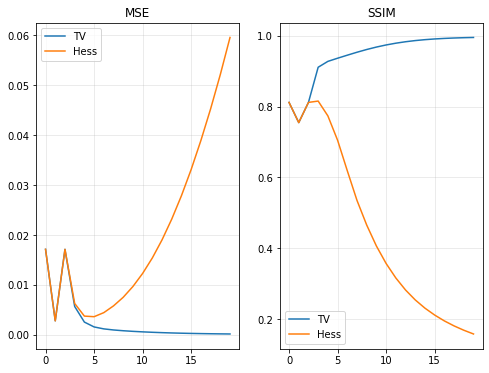

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,6))

ax[0].plot(error_MSE_TV, label = 'TV')
ax[0].plot(error_MSE_Hess, label = 'Hess')
ax[0].set_title('MSE')

ax[1].plot(error_SSIM_TV, label = 'TV')
ax[1].plot(error_SSIM_Hess, label = 'Hess')
ax[1].set_title('SSIM')

for a in ax:
  a.grid(True, alpha = 0.3)
  a.legend()

Text(0.5, 1.0, 'ADMM w/ Hess norm')

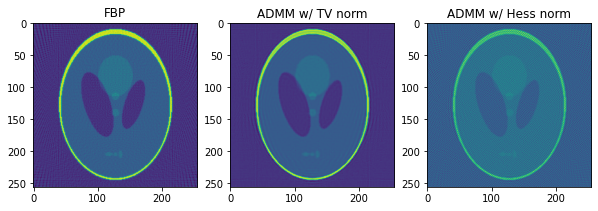

In [ ]:
fbp = hRT(y)

fig, ax = plt.subplots(1,3, figsize = (10, 8))

ax[0].imshow(fbp)
ax[0].set_title('FBP')

ax[1].imshow(x_ADMM)
ax[1].set_title('ADMM w/ TV norm')

ax[2].imshow(x_ADMM_Hess)
ax[2].set_title('ADMM w/ Hess norm')

In [45]:
# Testing for FBP/ADMM for database

# Load Dataframes
folder_paths = [f140114_5dpf]
dfs = [dl.ZebraDataset(dataset) for dataset in folder_paths]

for df in dfs:
  
  df.loadImages(sample = 'head')
  df.loadRegTransforms()
  df.applyRegistration(sample = 'head')

100%|██████████| 180/180 [00:12<00:00, 14.67it/s]


In [5]:
# Getting volume
currentvolume = df.getRegisteredVolume()

# Number of beams
beams = 360
# Angles
theta = np.linspace(0., 360.-360/beams, beams)

# Forward and backward operators
hR = lambda x: radon(x, theta, circle = True)
hRT = lambda sino: iradon(sino, theta, circle = True)

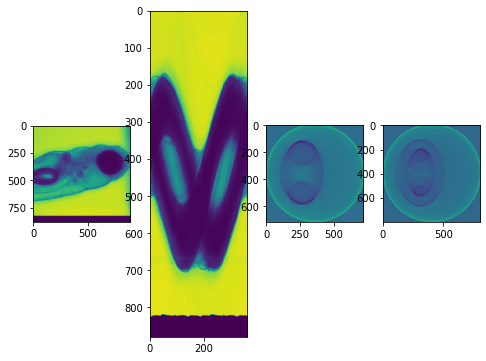

In [15]:
# Check sinograms
z = 750
fig, ax = plt.subplots(1,4, figsize = (8, 6))

ax[0].imshow(currentvolume[0,:,:], aspect = 'equal')
ax[1].imshow(currentvolume[:800,:,z].T, aspect = 'auto')
ax[2].imshow(hRT(currentvolume[:,80:-80,z].T), aspect = 'equal')
ax[3].imshow(hRT(currentvolume[:,:-80,z].T), aspect = 'equal')

In [75]:
###################### Pruebo TwIST

# denoise iterations
tv_iters = 5

Psi = lambda x,th:  rc.TVdenoise(x,2/th,tv_iters)
#  set the penalty function, to compute the objective
Phi = lambda x: rc.TVnorm(x)

#  regularization parameters (empirical)  
# Change if necessary - high value will blur the image
tau = 0.001              
tolA = 1e-4
#  -- TwIST ---------------------------
#  stop criterium:  the relative change in the objective function 
# % falls below 'ToleranceA'         
kwargs = {'Lambda':1e-4,
         'Psi':Psi,
         'Phi':Phi, 
         'GPU' : 0,
         'True_x': np.zeros(1), # choteada pero bueno
         'Monotone':1,
         'MaxiterA':10000,
         'Initialization':0,
         'StopCriterion':1,
       	 'ToleranceA':tolA,
         'Sparse' : 0,
         'Verbose': 1}

twist_method = lambda y, hR, hRT, true_img: rc.TwIST(y, hR, hRT, tau, kwargs, true_img)
admm_method = lambda y, hR, hRT, true_img:  rc.ADMM(y, hR, hRT, Psi, alpha = tau,
                                                delta = 1, max_iter = 10, phi = Phi, 
                                                tol = 1e-4, warm = 1, invert = 0, img = true_img,
                                                alpha_weight = False, alpha_decay = 0.6)

vol = df.getRegisteredVolume(useSegmented = True)
hRT = lambda sino, theta: iradon(sino, theta, circle = False)
hR = lambda x, theta: radon(x, theta, circle = False)

In [79]:
#### Pruebusqui de error contra FBP
projections = [180, 120, 90, 60, 45]
taus = [0.002, 0.006, 0.006, 0.006, 0.01]     # Change tau regarding the number of projections being used

N_z = 3
n_z = np.random.randint(0, vol.shape[2], N_z)  # Chooses random z (i dont subsample here so there's no conflict)

recs_x_twist = []; objs_twist = []; errs_mse_twist = []; errs_ssim_twist = []; trues_x_twist = []
recs_x_admm = []; objs_admm = []; errs_mse_admm = []; errs_ssim_admm = []; trues_x_admm = []

vol = df.getRegisteredVolume(useSegmented = True)
hRT = lambda sino, theta: iradon(sino, theta, circle = False)
hR = lambda x, theta: radon(x, theta, circle = False)

for proj, tau in zip(projections, taus):

  twist_method = lambda y, hR, hRT, true_img: rc.TwIST(y, hR, hRT, tau, kwargs, true_img)
  admm_method = lambda y, hR, hRT, true_img:  rc.ADMM(y, hR, hRT, Psi, alpha = tau,
                                                  delta = 1, max_iter = 10, phi = Phi, 
                                                  tol = 1e-4, warm = 1, invert = 0, img = true_img,
                                                  alpha_weight = False, alpha_decay = 0.6)


  rec_x_twist, obj_twist, err_mse_twist, err_ssim_twist, true_x_twist = iter_proj(twist_method,
                                                                                  hR, hRT, vol, 
                                                                                  df.maxAngle,
                                                                                  proj, n_z)

  rec_x_admm, obj_admm, err_mse_admm, err_ssim_admm, true_x_admm = iter_proj(admm_method,
                                                                             hR, hRT, vol,
                                                                             df.maxAngle,
                                                                             proj, n_z)
  
  recs_x_twist.append(rec_x_twist)
  objs_twist.append(obj_twist)
  errs_mse_twist.append(err_mse_twist) 
  errs_ssim_twist.append(err_ssim_twist)
  trues_x_twist.append(true_x_twist)

  recs_x_admm.append(rec_x_twist)
  objs_admm.append(obj_twist)
  errs_mse_admm.append(err_mse_twist) 
  errs_ssim_admm.append(err_ssim_twist)
  trues_x_admm.append(true_x_twist)

  admm_params = [recs_x_admm, objs_admm, errs_mse_admm, errs_ssim_admm, trues_x_admm]
  with open(results_folder+'ADMM_params_rec.pickle', 'wb') as handle:
      pickle.dump(admm_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
  twist_params = [recs_x_twist, objs_twist, errs_mse_twist, errs_ssim_twist, trues_x_twist]
  with open(results_folder+'twist_params_rec.pickle', 'wb') as handle:
      pickle.dump(twist_params, handle, protocol=pickle.HIGHEST_PROTOCOL)




1 
 Initial objective = 35289.477985001984,  nonzeros=0.0 

Iteration=2, objective=23729.953053239387, nz=280900,  criterion=3275.6293353716906

Iteration=3, objective=22637.80381586292, nz=280900,  criterion=460.2407914276834

Iteration=4, objective=22208.021172203193, nz=280900,  criterion=189.85173966326522

Incrementing S=2

Incrementing S=4

Incrementing S=8

Incrementing S=16

Iteration=5, objective=22136.76114573061, nz=280900,  criterion=32.08751735241379

Incrementing S=32

Incrementing S=64

Incrementing S=128

Incrementing S=256

Incrementing S=512

Incrementing S=1024

Incrementing S=2048

Incrementing S=4096

Incrementing S=8192

Incrementing S=16384

Incrementing S=32768

Incrementing S=65536

Incrementing S=131072

Incrementing S=262144

Incrementing S=524288

Incrementing S=1048576

Incrementing S=2097152

Incrementing S=4194304

Incrementing S=8388608

Incrementing S=16777216

Incrementing S=33554432

Incrementing S=67108864

Incrementing S=134217728

Incrementing S=26

NameError: ignored

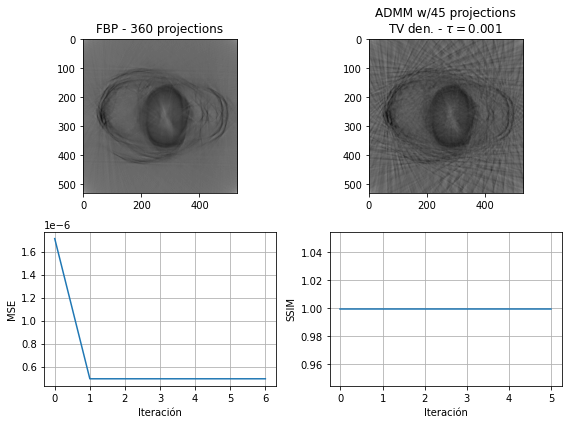

In [66]:
fig, ax = plt.subplots(2,2, figsize = (8,6))

ax[0,0].imshow(true_x[0], cmap = 'gray')
ax[0,0].set_title('FBP - 360 projections')

ax[0,1].imshow(rec_x[0], cmap = 'gray')
ax[0,1].set_title('\n'.join((r'ADMM w/45 projections', r'TV den. - $\tau = 0.001$')))

ax[1,0].plot(err_mse[0])
ax[1,0].set_ylabel('MSE')
ax[1,0].set_xlabel('Iteración')
ax[1,0].grid()

ax[1,1].plot(err_ssim[0])
ax[1,1].set_ylabel('SSIM')
ax[1,1].set_xlabel('Iteración')
ax[1,1].grid()

fig.tight_layout()

In [77]:
# Utilities
# Iterator to check projections
def iter_proj(method, hR, hRT, volume, max_angle, projections, n_z):
  '''
  With method, reconstruct N_z z-slices with a reduced number of projections
  Params:
    - method receives y, hR, hRT and true_img properly set up for the number of 
    projections required.
    - hRT receives sinogram 'y' and projection angles
    - hR receives image 'x' and projection angles
    - n_z provides the z-slices to be taken
  '''

  angle_step = max_angle//projections
  theta_sub, subsampled_vol = dl.subsample(volume, max_angle, angle_step) # Subset of angles and subsampled volume
  
  theta_full = np.linspace(0., max_angle-1, max_angle)  # Set of angles for full projection

  recons_x = []
  objectives = []
  errors_MSE = [] 
  errors_SSIM = [] 
  trues_x = []
  
  for z in n_z:
  
    y_full = volume[:,:, z].T          # Full sinogram
    y_sub = subsampled_vol[:,:, z].T   # subsampled sinogram
      
    true_img = hRT(y_full, theta_full)   # use full backprojected image

    # Forward and backward operators
    hR_sub = lambda x: hR(x, theta_sub)
    hRT_sub = lambda y: hRT(y, theta_sub)   
    
    # Iterative method with fewer projections
    x, objective, error_MSE, error_SSIM = method(y_sub, hR_sub, hRT_sub, true_img)   

    recons_x.append(x)
    trues_x.append(true_img)
    objectives.append(objective)
    errors_MSE.append(error_MSE)
    errors_SSIM.append(error_SSIM)

  return recons_x, objectives, errors_MSE, errors_SSIM, trues_x

In [80]:
theta = np.linspace(0., 180.-180/beams, beams)
hR = lambda x: radon(x, theta, circle = False)
hRT = lambda sino: iradon(sino, theta, circle = False)
kwargs = {'Lambda':0.04,
         'Psi':Psi,
         'Phi':Phi, 
         'GPU' : 0,
         'True_x': np.zeros(1), # choteada pero bueno
         'Monotone':1,
         'MaxiterA':10000,
         'Initialization':0,
         'StopCriterion':1,
       	 'ToleranceA':tolA,
         'Verbose': 1}

twist_method = lambda y, hR, hRT, true_img: rc.TwIST(y, hR, hRT, tau, kwargs, true_img)

twist_method(sino, hR, hRT, phant)

1 
 Initial objective = 14674595.000244752,  nonzeros=0.0 

Iteration=2, objective=2427.9584197508234, nz=65536,  criterion=9998.345468191994

Incrementing S=2

Iteration=3, objective=807.5814070510622, nz=65536,  criterion=6673.825216768157

Iteration=4, objective=445.3102808986159, nz=65536,  criterion=4485.87749779064

Iteration=5, objective=333.80777740870127, nz=65536,  criterion=2503.9283455326386

Iteration=6, objective=236.85141032024603, nz=65536,  criterion=2904.5568632676172

Iteration=7, objective=207.89627401675676, nz=65536,  criterion=1222.5021697924078

Iteration=8, objective=162.36554204652688, nz=65536,  criterion=2190.0696482208255

Iteration=9, objective=149.94683869859898, nz=65536,  criterion=764.8607698035611

Iteration=10, objective=123.01431611018883, nz=65536,  criterion=1796.1380728103202

Iteration=11, objective=115.3862212119969, nz=65536,  criterion=620.0981429965552

Iteration=12, objective=97.84433267280974, nz=65536,  criterion=1520.2758487911462

Itera

(array([[ 2.62005274e-03,  7.56911069e-04, -9.87528611e-06, ...,
          1.23275699e-04,  1.03268506e-03,  1.68399406e-03],
        [ 2.20503383e-03,  6.17379936e-04, -7.76183788e-05, ...,
         -1.60927768e-04,  4.80057143e-04,  8.30537737e-04],
        [ 1.83011564e-03,  7.85108366e-04, -3.32094520e-04, ...,
          4.07866232e-06,  2.22245660e-04,  6.20738388e-04],
        ...,
        [ 2.72183635e-04,  2.79390405e-04,  2.79155151e-04, ...,
          2.41678939e-04,  9.24632487e-05,  5.56042533e-05],
        [ 2.71472791e-04,  3.24728555e-04, -2.28090297e-05, ...,
         -3.36648506e-05,  2.71418091e-04,  1.72046904e-04],
        [ 1.33712104e-04,  1.84735029e-04,  5.30865060e-06, ...,
          1.87295052e-05,  4.25478693e-04,  4.86410768e-04]]),
 [14674595.000244752,
  2427.9584197508234,
  807.5814070510622,
  445.3102808986159,
  333.80777740870127,
  236.85141032024603,
  207.89627401675676,
  162.36554204652688,
  149.94683869859898,
  123.01431611018883,
  115.38622

In [71]:
# Reconstruction FBP pa probar
z = 750

max_angle = 360
angle_step = 4

new_angles, volume_subsample = subsample(currentvolume, max_angle, angle_step)

# Number of beams
beams = 360
theta = np.linspace(0., 360.-360/beams, beams)
hRT = lambda sino: iradon(sino, theta, circle = True)
full_fbp = hRT(currentvolume[:, :, z].T)

# Forward and backward operators
hR = lambda x: radon(x, new_angles, circle = True)
hRT = lambda sino: iradon(sino, new_angles, circle = True)
sub_fbp = hRT(volume_subsample[:, :, z].T)
alpha = 0.01

tv_iters = 3
Psi = lambda x,th:  rc.TVdenoise(x,2/th,tv_iters)
#  set the penalty function, to compute the objective
Phi = lambda x: rc.TVnorm(x)

# ADMM with TV norm
sub_ADMM_TV, objective, error_MSE_TV, error_SSIM_TV = rc.ADMM(volume_subsample[:, :, z].T, hR, hRT, Psi, alpha = alpha,
                                                delta = 1, max_iter = 10, phi = Phi, 
                                                tol = 1e-4, warm = 1, invert = 0, img = full_fbp,
                                                alpha_weight = False, alpha_decay = a_decay)
# Number of beams
beams = 360
theta = np.linspace(0., 360.-360/beams, beams)
hRT = lambda sino: iradon(sino, theta, circle = True)
full_fbp = hRT(currentvolume[:, :, z].T)

NameError: ignored

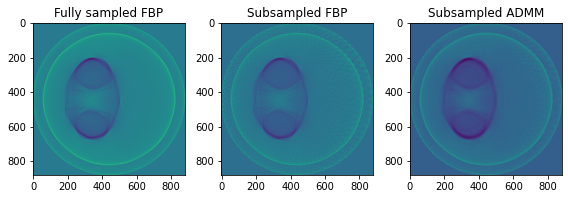

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (8, 6))

ax[0].imshow(full_fbp, aspect = 'equal')
ax[0].set_title('Fully sampled FBP')

ax[1].imshow(sub_fbp, aspect = 'equal')
ax[1].set_title('Subsampled FBP')

ax[2].imshow(sub_ADMM_TV, aspect = 'equal')
ax[2].set_title('Subsampled ADMM')

fig.tight_layout()
fig.savefig(results_folder+'ADMM-Comparison-P{}.pdf'.format(max_angle/angle_step), 
            bbox_inches = 'tight')

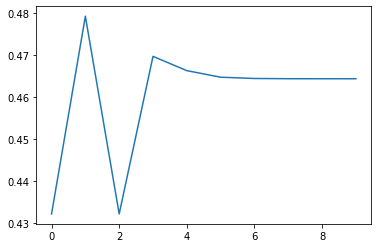

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(error_SSIM_TV)

In [ ]:
fig.